In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from ipywidgets import IntProgress
from IPython.display import display

In [4]:
from var_table import VarTable

In [5]:
from cost_calculator_factory import CostCalculatorFactory
from multibinary_converter import MultiBinaryConverter
from multidiscrete_converter import MultiDiscreteConverter
from fitness_calculator import FitnessCalculator

In [6]:
from genetic_multibinary_space_config import GeneticMultiBinarySpaceConfig
from genetic_multidiscrete_space_config import GeneticMultiDiscreteSpaceConfig
from genetic_config import GeneticConfig
from genetic_solver import GeneticSolver

In [7]:
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

In [8]:
from rl_multibinary_config import RlMultiBinaryConfig
from rl_multidiscrete_config import RlMultiDiscreteConfig
from rl_graphic import RlGraphic
from rl_env import RlEnv
from rl_solver import RlSolver

In [9]:
from model_builder import ModelBuilder
from solve_action import SolveAction

In [10]:
from cost_calculator_factory import CostCalculatorFactory

In [11]:
M = 10 ** 100
dtype = np.int64
policy = 'MlpPolicy'

In [12]:
var_table = VarTable()

In [13]:
class ExperimentForGroup:
    def __init__(self, group_name, experiments_count):
        self.group_name = group_name
        self.experiments_count = experiments_count
        
        # fitnesses
        self.binary_genetic_fitnesses = []
        self.discrete_genetic_fitnesses = []
        
        self.binary_rl_a2c_fitnessses = []
        self.binary_rl_ppo_fitnessess = []
        self.discrete_rl_a2c_fitnesses = []
        self.discrete_rl_ppo_fitnesses = []

        self.glpk_fitnesses = []
        self.xpress_fitnesses = []
        self.mpec_minlp_fitnesses = []
        self.ilogcp_fitnesses = []

        # durations
        self.binary_genetic_durations = []
        self.discrete_genetic_durations = []

        self.binary_rl_a2c_durations = []
        self.binary_rl_ppo_durations = []
        self.discrete_rl_a2c_durations = []
        self.discrete_rl_ppo_durations = []

        self.glpk_durations = []
        self.xpress_durations = []
        self.mpec_minlp_durations = []
        self.ilogcp_durations = []


    def make(self):
        progress = IntProgress(min=0, max=self.experiments_count, value=0, description=self.group_name, bar_style='success')
        display(progress)
        for experiment_number in range(1, self.experiments_count + 1):
            self.make_experiment(experiment_number, progress)
        fitnesses_dataset = {
            'binary genetic': self.binary_genetic_fitnesses,
            'discrete genetic': self.discrete_genetic_fitnesses,
            'binary rl a2c': self.binary_rl_a2c_fitnessses,
            'binary rl ppo': self.binary_rl_ppo_fitnessess,
            'discrete rl a2c': self.discrete_rl_a2c_fitnesses,
            'discrete rl ppo': self.discrete_rl_ppo_fitnesses,
            'glpk': self.glpk_fitnesses,
            'xpress': self.xpress_fitnesses,
            'mpec_minlp': self.mpec_minlp_fitnesses,
            'ilogcp': self.ilogcp_fitnesses
        }

        durations_dataset = {
            'binary genetic': self.binary_genetic_durations,
            'discrete genetic': self.discrete_genetic_durations,
            'binary rl a2c': self.binary_rl_a2c_durations,
            'binary rl ppo': self.binary_rl_ppo_durations,
            'discrete rl a2c': self.discrete_rl_a2c_durations,
            'discrete rl ppo': self.discrete_rl_ppo_durations,
            'glpk': self.glpk_durations,
            'xpress': self.xpress_durations,
            'mpec_minlp': self.mpec_minlp_durations,
            'ilogcp': self.ilogcp_durations
        }
        
        self.violinplot(fitnesses_dataset, 'fitnesses'),
        self.violinplot(durations_dataset, 'durations')
        

    def violinplot(self, dataset, name):
        df = pd.DataFrame(dataset)
        df_melted = pd.melt(df)
        title = self.group_name + ' ' + name
        sns.violinplot(x='variable', y='value', data=df_melted, width=0.5, dodge=False, hue='variable').set(title=title)
        plt.xticks(rotation=75)
        plt.xlabel('')
        plt.ylabel('fitness')
        plt.show()

    def make_experiment(self, experiment_number, progress):
        nested_directory = var_table.get_nested_directory(self.group_name, experiment_number)
        T_file_path = '{}/T.csv'.format(nested_directory)
        D_file_path = '{}/D.csv'.format(nested_directory)
        C_file_path = '{}/C.csv'.format(nested_directory)
        E_file_path = '{}/E.csv'.format(nested_directory)
        T_df = pd.read_csv(T_file_path, index_col=False, header=None)
        D_df = pd.read_csv(D_file_path, index_col=False, header=None)
        C_df = pd.read_csv(C_file_path, index_col=False, header=None)
        E_df = pd.read_csv(E_file_path, index_col=False, header=None)
        T = T_df.to_numpy()
        D = D_df.to_numpy()
        C = C_df.to_numpy()
        E = E_df.to_numpy()
        
        cost_calculator_factory = CostCalculatorFactory(T, D, C, E)
        m = np.shape(T)[1]
        k = var_table.generate_k(self.group_name)
        
        # genetic
        binary_genetic_solver = self.create_binary_genetic_solver(m, k, cost_calculator_factory)
        discrete_genetic_solver = self.create_discrete_genetic_solver(m, k, cost_calculator_factory)

        binary_genetic_solution, binary_genetic_solution_fitness, binary_genetic_solution_idx, binary_genetic_solution_duration = binary_genetic_solver.solve()
        discrete_genetic_solution, discrete_genetic_solution_fitness, discrete_genetic_solution_idx, discrete_genetic_solution_duration = discrete_genetic_solver.solve()
        
        self.binary_genetic_fitnesses.append(binary_genetic_solution_fitness)
        self.discrete_genetic_fitnesses.append(discrete_genetic_solution_fitness)

        self.binary_genetic_durations.append(binary_genetic_solution_duration)
        self.discrete_genetic_durations.append(discrete_genetic_solution_duration)

        # rl
        binary_rl_a2c_solver = self.create_binary_rl_solver(m, k, cost_calculator_factory, A2C)
        binary_rl_ppo_solver = self.create_binary_rl_solver(m, k, cost_calculator_factory, PPO)
        discrete_rl_a2c_solver = self.create_discrete_rl_solver(m, k, cost_calculator_factory, A2C)
        discrete_rl_ppo_solver = self.create_discrete_rl_solver(m, k, cost_calculator_factory, PPO)

        binary_rl_a2c_fitness, binary_rl_a2c_solution, binary_rl_a2c_duration = binary_rl_a2c_solver.solve()
        binary_rl_ppo_fitness, binary_rl_ppo_solution, binary_rl_ppo_duration = binary_rl_ppo_solver.solve()
        discrete_rl_a2c_fitness, discrete_rl_a2c_solution, discrete_rl_a2c_duration = discrete_rl_a2c_solver.solve()
        discrete_rl_ppo_fitness, discrete_rl_ppo_solution, discrete_rl_ppo_duration = discrete_rl_ppo_solver.solve()

        self.binary_rl_a2c_fitnessses.append(binary_rl_a2c_fitness)
        self.binary_rl_ppo_fitnessess.append(binary_rl_ppo_fitness)
        self.discrete_rl_a2c_fitnesses.append(discrete_rl_a2c_fitness)
        self.discrete_rl_ppo_fitnesses.append(discrete_rl_ppo_fitness)

        self.binary_rl_a2c_durations.append(binary_rl_a2c_duration)
        self.binary_rl_ppo_durations.append(binary_rl_ppo_duration)
        self.discrete_rl_a2c_durations.append(discrete_rl_a2c_duration)
        self.discrete_rl_ppo_durations.append(discrete_rl_ppo_duration)

        # solvers
        glpk_solver = self.create_solver(M, k, T, D, C, E, 'glpk')
        xpress_solver = self.create_solver(M, k, T, D, C, E, 'xpress')
        mpec_minlp_solver = self.create_solver(M, k, T, D, C, E, 'mpec_minlp')
        ilogcp_solver = self.create_solver(M, k, T, D, C, E, 'ilogcp')

        # glpk
        glpk_solve_result = glpk_solver.solve()
        glpk_instance = glpk_solve_result.instance
        glpk_duration = glpk_solve_result.duration
        glpk_A = glpk_instance.A
        glpk_A = glpk_solve_result.to_mtx_with_values(glpk_A)
        glpk_cost_calculator = cost_calculator_factory.get_cost_calculator(glpk_A)
        glpk_fitness = 1 / glpk_cost_calculator.calculate()
        
        self.glpk_fitnesses.append(glpk_fitness)
        self.glpk_durations.append(glpk_duration)

        # xpress
        xpress_solve_result = xpress_solver.solve()
        xpress_instance = xpress_solve_result.instance
        xpress_duration = xpress_solve_result.duration
        xpress_A = xpress_instance.A
        xpress_A = xpress_solve_result.to_mtx_with_values(xpress_A)
        xpress_cost_calculator = cost_calculator_factory.get_cost_calculator(xpress_A)
        xpress_fitness = 1 / xpress_cost_calculator.calculate()
        
        self.xpress_fitnesses.append(xpress_fitness)
        self.xpress_durations.append(xpress_duration)

        # mpec_minlp
        mpec_minlp_solve_result = mpec_minlp_solver.solve()
        mpec_minlp_instance = mpec_minlp_solve_result.instance
        mpec_minlp_duration = mpec_minlp_solve_result.duration
        mpec_minlp_A = mpec_minlp_instance.A
        mpec_minlp_A = mpec_minlp_solve_result.to_mtx_with_values(mpec_minlp_A)
        mpec_minlp_cost_calculator = cost_calculator_factory.get_cost_calculator(mpec_minlp_A)
        mpec_minlp_fitness = 1 / mpec_minlp_cost_calculator.calculate()
        
        self.mpec_minlp_fitnesses.append(mpec_minlp_fitness)
        self.mpec_minlp_durations.append(mpec_minlp_duration)

        # ilogcp
        ilogcp_solve_result = ilogcp_solver.solve()
        ilogcp_instance = ilogcp_solve_result.instance
        ilogcp_duration = ilogcp_solve_result.duration
        ilogcp_A = ilogcp_instance.A
        ilogcp_A = ilogcp_solve_result.to_mtx_with_values(ilogcp_A)
        ilogcp_cost_calculator = cost_calculator_factory.get_cost_calculator(ilogcp_A)
        ilogcp_fitness = 1 / ilogcp_cost_calculator.calculate()
        
        self.ilogcp_fitnesses.append(ilogcp_fitness)
        self.ilogcp_durations.append(ilogcp_duration)


        progress.value += 1
    
    # glpk, xpress, mpec_minlp, ilogcp
    def create_solver(self, M, k, T, D, C, E, solver_name):
        model_builder = ModelBuilder(M, k, T, D, C, E)
        model = model_builder.build()
        solver = SolveAction(model, solver_name)
        return solver

    def create_binary_genetic_solver(self, m, k, cost_calculator_factory):
        converter = MultiBinaryConverter(m, k)
        fitness_calculator = FitnessCalculator(cost_calculator_factory, converter)
        space_config = GeneticMultiBinarySpaceConfig(m, k)
        config = GeneticConfig(space_config)
        description = 'binary genetic'
        progress = IntProgress(min=0, max=config.num_generations, value=0, description=description, bar_style='success')
        solver = GeneticSolver(config, fitness_calculator, progress)
        return solver

    def create_discrete_genetic_solver(self, m, k, cost_calculator_factory):
        converter = MultiDiscreteConverter(m, k)
        fitness_calculator = FitnessCalculator(cost_calculator_factory, converter)
        space_config = GeneticMultiDiscreteSpaceConfig(m, k)
        config = GeneticConfig(space_config)
        description = 'discrete genetic'
        progress = IntProgress(min=0, max=config.num_generations, value=0, description=description, bar_style='success')
        solver = GeneticSolver(config, fitness_calculator, progress)
        return solver
    
    def create_binary_rl_solver(self, m, k, cost_calculator_factory, algorithm):
        total_timesteps = 100
        config = RlMultiBinaryConfig(m, k, dtype)
        converter = MultiBinaryConverter(m, k)
        fitness_calcultor = FitnessCalculator(cost_calculator_factory, converter)
        progress = IntProgress(min=0, max=total_timesteps, value=0, description='multibinary', bar_style='success')
        graphic = RlGraphic('multibinary')
        env = RlEnv(config, fitness_calcultor, progress, graphic)
        check_env(env)
        model = algorithm(policy, env)
        solver = RlSolver(model, total_timesteps)
        return solver
    
    def create_discrete_rl_solver(self, m, k, cost_calculator_factory, algorithm):
        total_timesteps = 100
        config = RlMultiDiscreteConfig(m, k, dtype)
        converter = MultiDiscreteConverter(m, k)
        fitness_calculator = FitnessCalculator(cost_calculator_factory, converter)
        progress = IntProgress(min=0, max=total_timesteps, value=0, description='multidiscrete', bar_style='success')
        graphic = RlGraphic('multidiscrete')
        env = RlEnv(config, fitness_calculator, progress, graphic)
        check_env(env)
        model = algorithm(policy, env)
        solver = RlSolver(model, total_timesteps)
        return solver


In [14]:
group_name = 'G0'
experiments_count = 100

In [15]:
experiment_for_group = ExperimentForGroup(group_name, experiments_count)

IntProgress(value=0, bar_style='success', description='G0')

the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None
the transformation: None


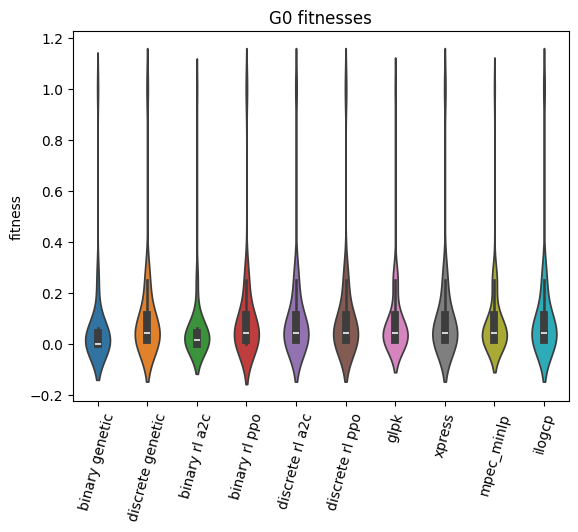

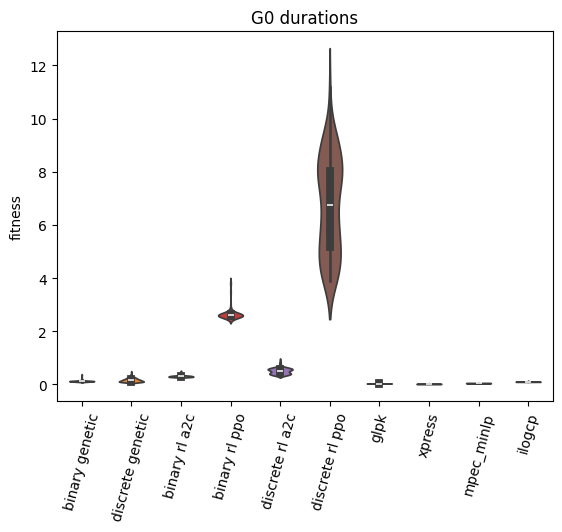

In [16]:
experiment_for_group.make()